#### Working on recreating the emcee demo with fitting the star formation history.
ONLY working with the following variables in the fsps documentation:
* tau
* tage
* fburst
* tburst (calculated from fage_burst)

--------------
First need to double check that changing the SFH parameters actually changes the spectra

In [18]:
from prospectFunctionsSFH import *
from matplotlib.pyplot import *
from prospect.models.templates import TemplateLibrary

In [25]:
tages = np.linspace(0.01, .5, 5)

In [70]:
run_params = {}
run_params['mass'] = 1e8
run_params['zred'] = 3.548
run_params['logzsol'] = 0.0 # Solar metallicity
# run_params['tage'] = 0.0
run_params['dust2'] = 0.0
run_params['imf_type'] = 2
run_params['sfh'] = 4
run_params['tau'] = 1
run_params['tage'] = tages[0]
run_params['zcontinuous'] = 1

In [9]:
obs = getObs(**run_params)
sps = getSps(**run_params)

In [10]:
wspec = sps.wavelengths

In [31]:
specs = np.empty([len(tages), len(wspec)])
specs.shape

(5, 5994)

In [32]:
for itage,tage in enumerate(tages):
    run_params['tage'] = tage
    model = getModel(**run_params)
    spec, phot, mfrac = model.predict(model.theta, obs=obs, sps=sps)
    specs[itage,:] = spec

In [12]:
init_spec, init_phot, init_mfrac = model.predict(model.theta, obs=obs, sps=sps)

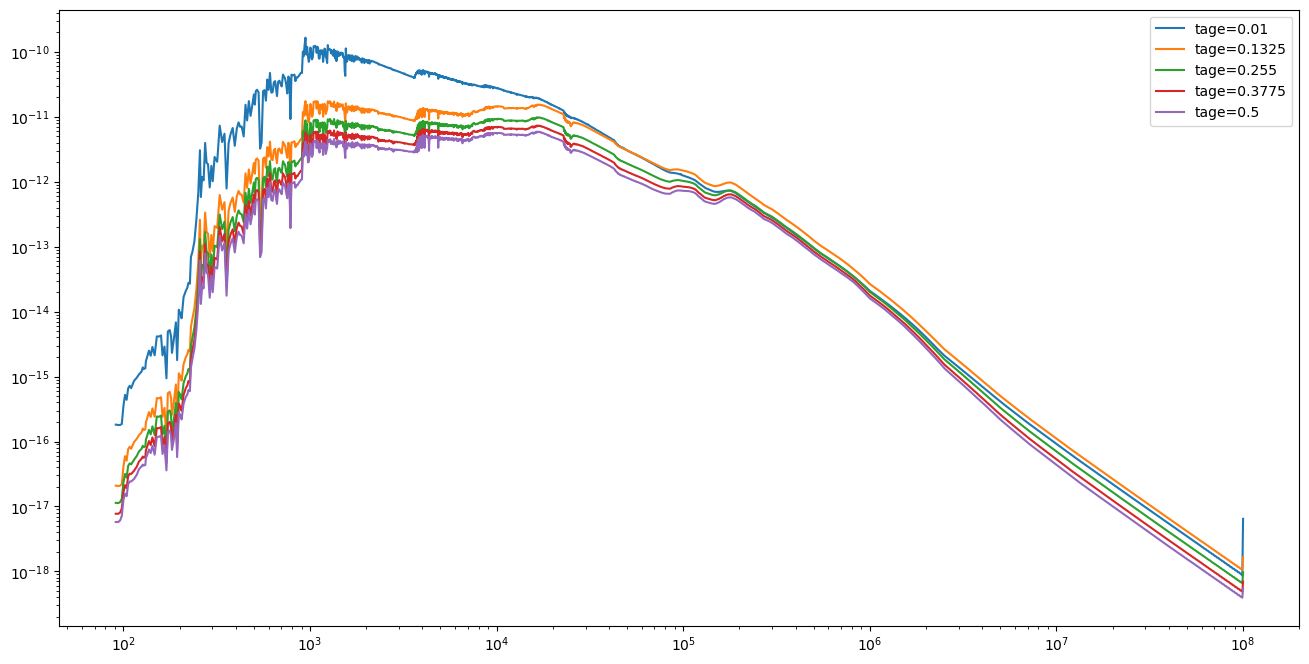

In [38]:
figure(figsize=(16,8))
for i,spec in enumerate(specs):
    loglog(wspec, spec, label=f'tage={tages[i]}')

legend()
show()

In [39]:
from prospect.plotting.sfh import parametric_sfr

In [40]:
help(parametric_sfr)

Help on function parametric_sfr in module prospect.plotting.sfh:

parametric_sfr(times=None, tavg=0.001, tage=1, **sfh)
    Return the SFR (Msun/yr) for the given parameters of a parametric SFH,
    optionally averaging over some timescale.

    :param times: (optional, ndarray)
        If given, a set of *lookback* times where you want to calculate the sfr,
        same units as `tau` and `tage`

    :param tavg: (optional, float, default: 1e-3)
        If non-zero, average the SFR over the last `tavg` Gyr. This can help
        capture bursts.  If zero, the instantaneous SFR will be returned.

    :param sfh: optional keywords
        FSPS parametric SFH parametrs, e.g. sfh, tage, tau, sf_trunc

    :returns sfr:
        SFR in M_sun/year either for the lookback times given by `times` or at
        lookback time 0 if no times are given.  The SFR will either be
        instaneous or averaged over the last `tavg` Gyr.



In [56]:
def test_parametric_sfr(times=None, tavg=1e-3, tage=1, **sfh):
    """Return the SFR (Msun/yr) for the given parameters of a parametric SFH,
    optionally averaging over some timescale.

    :param times: (optional, ndarray)
        If given, a set of *lookback* times where you want to calculate the sfr,
        same units as `tau` and `tage`

    :param tavg: (optional, float, default: 1e-3)
        If non-zero, average the SFR over the last `tavg` Gyr. This can help
        capture bursts.  If zero, the instantaneous SFR will be returned.

    :param sfh: optional keywords
        FSPS parametric SFH parametrs, e.g. sfh, tage, tau, sf_trunc

    :returns sfr:
        SFR in M_sun/year either for the lookback times given by `times` or at
        lookback time 0 if no times are given.  The SFR will either be
        instaneous or averaged over the last `tavg` Gyr.
    """
    if times is None:
        times = np.array(tage)

    pset = parametric_pset(tage=tage, **sfh)
    sfr, mass = compute_mass_formed(tage - times, pset)
    if tavg > 0:
        _, meps = compute_mass_formed((tage - times) - tavg, pset)
        sfr = (mass - meps) / (tavg * 1e9)
    return sfr

In [71]:
from astropy.cosmology import Planck13

times = np.linspace(0.01, 2, 5)

run_params

{'mass': 100000000.0,
 'zred': 3.548,
 'logzsol': 0.0,
 'dust2': 0.0,
 'imf_type': 2,
 'sfh': 4,
 'tau': 1,
 'tage': np.float64(0.01),
 'zcontinuous': 1}

In [72]:
parametric_sfr(times=times, **run_params)

array([nan, nan, nan, nan, nan])

In [19]:
TemplateLibrary['burst_sfh']

{'tburst': {'N': 1,
  'isfree': False,
  'init': 0.0,
  'units': 'Gyr',
  'prior': None,
  'depends_on': <function prospect.models.transforms.tburst_from_fage(tage=0.0, fage_burst=0.0, **extras)>},
 'fburst': {'N': 1,
  'isfree': False,
  'init': 0.0,
  'units': 'fraction of total mass formed in the burst',
  'prior': <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=0.5)},
 'fage_burst': {'N': 1,
  'isfree': False,
  'init': 0.0,
  'units': 'time at wich burst happens, as a fraction of `tage`',
  'prior': <class 'prospect.models.priors.TopHat'>(mini=0.5,maxi=1.0)}}

In [ ]:
import fsps

In [ ]:
sp = fsps.StellarPopulation(imf_type=2, zcontinuous=1)

In [ ]:
sp.params['sfh'] = 1

In [ ]:
sp.params['tage']

---------
Then check that running through loops of SFH (e-folding (1) or delayed tau model (4)?) will actually change the SFH if the sps is the same